# Data Cleaning, Feature Engineering, and Exploratory Data Analysis #

#### Imports ####

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
dogs_v_kids = pd.read_csv('../data/dogs_v_children.csv')

## Data Cleaning ##

In [3]:
dogs_v_kids.columns

Index(['subreddit', 'selftext', 'author_fullname', 'gilded', 'title',
       'link_flair_richtext', 'subreddit_name_prefixed', 'hidden', 'pwls',
       'link_flair_css_class', 'thumbnail_height', 'top_awarded_type',
       'hide_score', 'quarantine', 'link_flair_text_color', 'upvote_ratio',
       'author_flair_background_color', 'subreddit_type',
       'total_awards_received', 'media_embed', 'thumbnail_width',
       'author_flair_template_id', 'is_original_content', 'secure_media',
       'is_reddit_media_domain', 'is_meta', 'category', 'secure_media_embed',
       'link_flair_text', 'score', 'is_created_from_ads_ui', 'author_premium',
       'thumbnail', 'edited', 'author_flair_css_class',
       'author_flair_richtext', 'gildings', 'content_categories', 'is_self',
       'link_flair_type', 'wls', 'removed_by_category', 'author_flair_type',
       'domain', 'allow_live_comments', 'suggested_sort', 'view_count',
       'archived', 'no_follow', 'is_crosspostable', 'pinned', 'over_18'

There are quite a number of columns in this dataset that I have little interest in for this project. I'll reassign my dataframe to only include the columns I want:

In [4]:
dogs_v_kids = dogs_v_kids[['subreddit', 'selftext', 'title', 'author', 'utc_datetime_str']]
dogs_v_kids.head()        

,subreddit,selftext,title,author,utc_datetime_str
0,dogs,"We have a 1 year old maltese shihtzu, we have ...",On lead greetings,M3409,2023-03-02 00:16:11
1,dogs,"Color, pile thickness, pattern?\n\nI have a mi...",Home carpet recommendations?,GoodMoGo,2023-03-02 00:15:20
2,dogs,"Hello, Noah is a white german shepherd, he has...",Dog epilepsy,kekalam,2023-03-02 00:14:14
3,dogs,So I’ve moved in to my aunts house and she own...,Advice needed,mfgoodguy,2023-03-02 00:12:16
4,dogs,This is an app that could be useful to find a...,Mappet is an app for dogs lovers,SalvatoreScalia,2023-03-02 00:05:20


I don't feel like **'selftext'** is a particularly descriptive or intuitive name, so I'm going to change that:

In [5]:
dogs_v_kids.rename(columns = {'selftext': 'post'}, inplace=True)

I'll also change **'utc_datetime_str'** to a datetime dtype

In [6]:
dogs_v_kids['utc_datetime_str'] = pd.to_datetime(dogs_v_kids['utc_datetime_str'])
dogs_v_kids.dtypes

subreddit                   object
post                        object
title                       object
author                      object
utc_datetime_str    datetime64[ns]
dtype: object

Let's check for nulls:

In [7]:
dogs_v_kids.isna().sum()

subreddit           0
post                1
title               0
author              0
utc_datetime_str    0
dtype: int64

Looks like there is just the one in **'post'**. Let's take a look:

In [8]:
dogs_v_kids[dogs_v_kids['post'].isna()]

,subreddit,post,title,author,utc_datetime_str
56,dogs,NaN,LPT: Make sure your pets travel in the human s...,wattatam,2023-03-01 15:46:53


It looks like this post just has all of the text in the title. I'll fill 'post' with an empty string

In [9]:
dogs_v_kids.fillna('', inplace=True)
dogs_v_kids.isna().sum()

subreddit           0
post                0
title               0
author              0
utc_datetime_str    0
dtype: int64

Finally, I'll binarize my y variable, which is **'subreddit'**. Since the ultimate goal is to reach parents, I'll set **'Parenting'** to 1 (true) and **'dogs'** to 0 (false)

In [10]:
dogs_v_kids['subreddit'] = dogs_v_kids['subreddit'].map({'Parenting': 1, 'dogs': 0})

## Feature Engineering ##

I'm going to create some variables that measure the lengths of posts and titles, as I am interested in seeing if there is a notable difference in post length between the two subreddits:

In [11]:
dogs_v_kids['post_length'] = [len(post) for post in dogs_v_kids['post']]
dogs_v_kids['post_word_count'] = [len(post.split()) for post in dogs_v_kids['post']]
dogs_v_kids['title_length'] = [len(title) for title in dogs_v_kids['title']]
dogs_v_kids['title_word_count'] = [len(title.split()) for title in dogs_v_kids['title']]
dogs_v_kids.head()

,subreddit,post,title,author,utc_datetime_str,post_length,post_word_count,title_length,title_word_count
0,0,"We have a 1 year old maltese shihtzu, we have ...",On lead greetings,M3409,2023-03-02 00:16:11,661,129,17,3
1,0,"Color, pile thickness, pattern?\n\nI have a mi...",Home carpet recommendations?,GoodMoGo,2023-03-02 00:15:20,326,55,28,3
2,0,"Hello, Noah is a white german shepherd, he has...",Dog epilepsy,kekalam,2023-03-02 00:14:14,376,75,12,2
3,0,So I’ve moved in to my aunts house and she own...,Advice needed,mfgoodguy,2023-03-02 00:12:16,1037,207,13,2
4,0,This is an app that could be useful to find a...,Mappet is an app for dogs lovers,SalvatoreScalia,2023-03-02 00:05:20,308,28,32,7


I'll also create a column that combines my two text columns, in order to simplify later steps:

In [12]:
dogs_v_kids['title_post'] = dogs_v_kids['title'] + ' ' + dogs_v_kids['post']

Now I'll save my dataframe:

In [13]:
dogs_v_kids.to_csv('../data/dogs_v_kids_cleaned.csv', index=False)

## EDA ##

Longest and shortest Posts by word count:

In [14]:
dogs_v_kids.sort_values('post_word_count').head()

,subreddit,post,title,author,utc_datetime_str,post_length,post_word_count,title_length,title_word_count,title_post
56,0,,LPT: Make sure your pets travel in the human s...,wattatam,2023-03-01 15:46:53,0,0,63,13,LPT: Make sure your pets travel in the human s...
743,0,[https://www.thesun.co.uk/news/21445882/twitch...,Horror accident - Streamer running over dog (T...,fancy_the_rat,2023-02-24 19:27:58,158,1,76,10,Horror accident - Streamer running over dog (T...
112,0,Title.,Why is charging more for puppies from a given ...,Whisdeer,2023-03-01 01:19:59,6,1,83,15,Why is charging more for puppies from a given ...
1596,0,ty,n&amp;d vs acana. for a golden retr pup,Funny_Razzmatazz_751,2023-02-19 09:05:54,2,1,39,8,n&amp;d vs acana. for a golden retr pup ty
145,0,.,Would it be bad to gently wrap up my long-hair...,the-greenest-thumb,2023-02-28 20:20:52,1,1,229,46,Would it be bad to gently wrap up my long-hair...


In [15]:
dogs_v_kids.sort_values('post_word_count', ascending=False).head()

,subreddit,post,title,author,utc_datetime_str,post_length,post_word_count,title_length,title_word_count,title_post
1459,0,Hi everyone! I’ve been thinking for far too lo...,Considering a new dog- Rhodesian Ridgeback?,Crysser812,2023-02-20 02:54:16,15303,2781,43,6,Considering a new dog- Rhodesian Ridgeback? Hi...
2654,1,&gt;! Prim ajutor bebelusi - Cum prevenim acci...,Prim ajutor bebelusi - Cum prevenim accidentel...,Car-BoyKidland,2023-02-23 07:08:50,15171,2452,70,10,Prim ajutor bebelusi - Cum prevenim accidentel...
1198,0,\*\*Introduction\*\*\n\n1) Will this be your f...,Grateful for your breed input for family compa...,korzoffthedogspider,2023-02-21 20:04:18,10057,1855,90,14,Grateful for your breed input for family compa...
1003,0,###**Introduction**\n\n1) Will this be your f...,Would appreciate any outside look over my bree...,lurkielurker,2023-02-23 00:07:04,9220,1686,141,24,Would appreciate any outside look over my bree...
162,0,\n\nI feel like I have firts to explain why. I...,I had to give up my dog for aggression and I’m...,scorefall,2023-02-28 18:11:01,7923,1575,59,13,I had to give up my dog for aggression and I’m...


Distributions of Post and Title length:

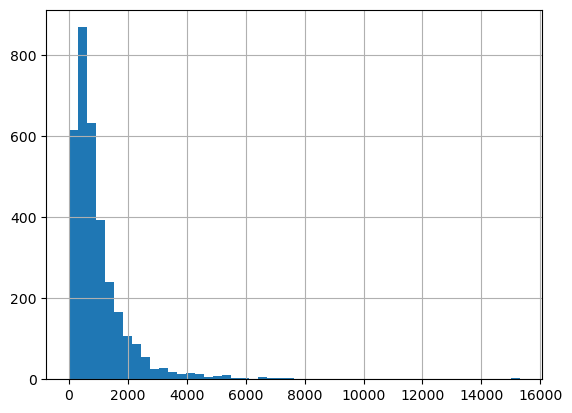

In [16]:
dogs_v_kids['post_length'].hist(bins=50);

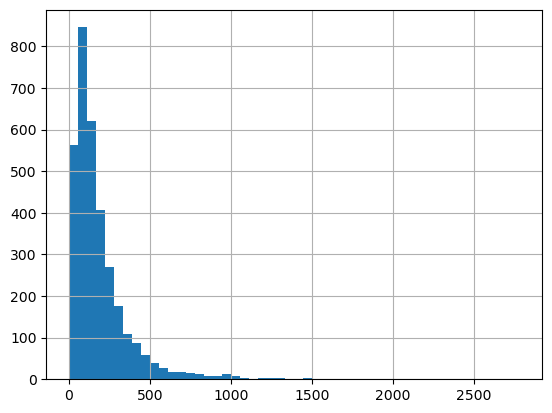

In [17]:
dogs_v_kids['post_word_count'].hist(bins=50);

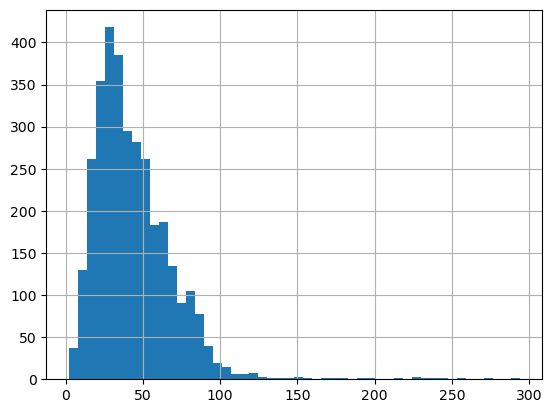

In [18]:
dogs_v_kids['title_length'].hist(bins=50);

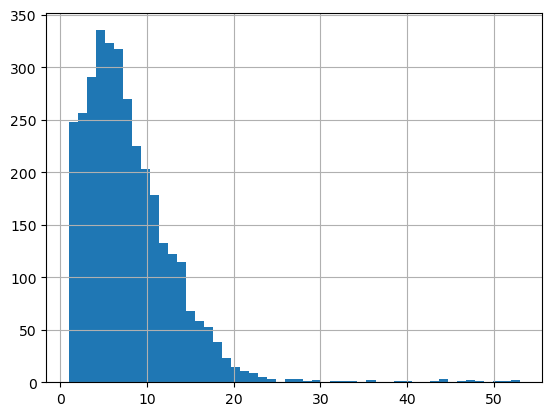

In [19]:
dogs_v_kids['title_word_count'].hist(bins=50);

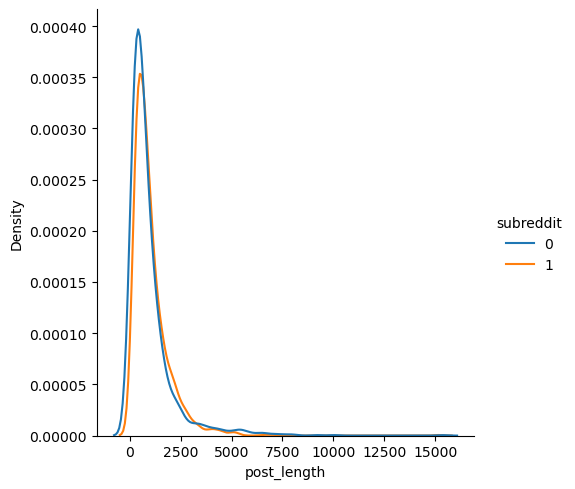

In [20]:
sns.displot(x=dogs_v_kids['post_length'], hue=dogs_v_kids['subreddit'], kind='kde');

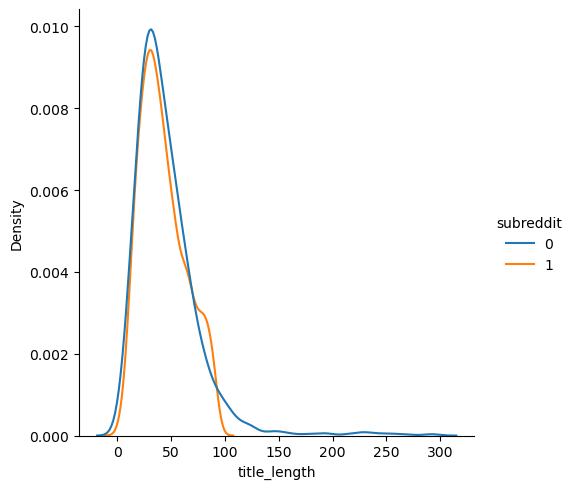

In [21]:
sns.displot(x=dogs_v_kids['title_length'], hue=dogs_v_kids['subreddit'], kind='kde');

Now I'll use **CountVectorizer** to vectorize the two text variables for the purpose of EDA

In [22]:
cvec = CountVectorizer(stop_words='english')
vectorized = cvec.fit_transform(dogs_v_kids['title_post'])
vdf = pd.DataFrame(vectorized.todense(), columns = cvec.get_feature_names_out())

In [23]:
vdf.head()

,00,000,0063215225,00am,01,02,03,04,04am,05,...,παρκο,περιοχη,πολλα,πολλους,πολυ,σε,συμβολισμους,την,τουριστικη,χρονια
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


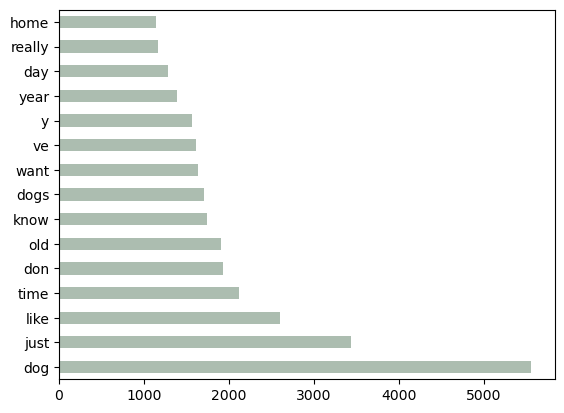

In [32]:
vdf.sum().sort_values(ascending=False).head(15).plot(kind='barh', color='#acbdb0');
plt.savefig('../images/most_common_words.png')
# Copied w/ minor alterations from lesson 505

I'm noticing the words 'dog' and 'dogs' in the top 15. I'm torn as to whether or not I should add these to my stop words when it comes time to fit models. On the one hand, it occurs to me that leaving these words in might provide something of a crutch for my model, making the process far too easy in some cases. On the other, not allowing the model to see what would almost certainly be one of the most determinitive words could unnecessarily handicap it in real world applications

Let's look at top words by each of the subreddits:

*Note: I had to change the name of my **'subreddit'** variable in order to bring it into this dataframe, as the word 'subreddit' appears in the text of several posts*

In [25]:
vdf['y'] = dogs_v_kids['subreddit']

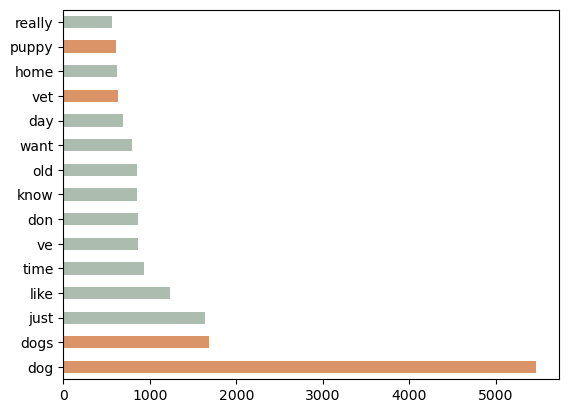

In [34]:
vdf[vdf['y'] == 0].sum().sort_values(ascending=False).head(15).plot(kind='barh', 
                                                                    color=['#da9468', '#da9468', '#acbdb0', '#acbdb0', 
                                                                           '#acbdb0', '#acbdb0', '#acbdb0', '#acbdb0',
                                                                           '#acbdb0', '#acbdb0', '#acbdb0', '#da9468',
                                                                           '#acbdb0', '#da9468', '#acbdb0']);
plt.savefig('../images/most_common_words_rdogs.png')

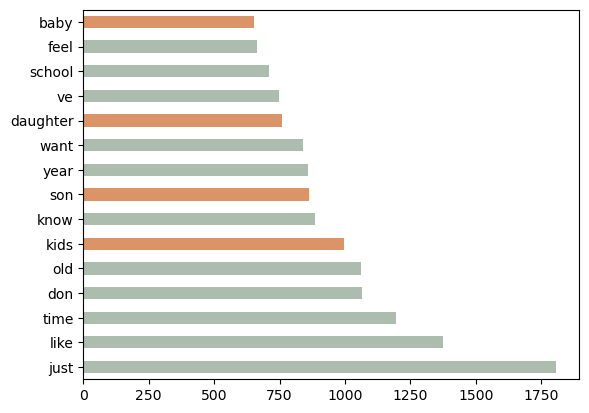

In [36]:
vdf.drop(columns='y')[vdf['y'] == 1].sum().sort_values(ascending=False).head(15).plot(kind='barh',
                                                                                      color=['#acbdb0', '#acbdb0', '#acbdb0', '#acbdb0',
                                                                                             '#acbdb0', '#da9468', '#acbdb0', '#da9468',
                                                                                             '#acbdb0', '#acbdb0', '#da9468', '#acbdb0',
                                                                                             '#acbdb0', '#acbdb0', '#da9468']);
plt.savefig('../images/most_common_words_rparenting.png')